In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
df_teams = pd.DataFrame(teams.get_teams())
team_id_list = list(df_teams.id)

#### Save the player_id/team_id combo to a csv

In [3]:
filename = 'team_player_ids.csv'
if os.path.isfile(filename):
    team_player_ids =  pd.read_csv(filename, index_col=0)
else:
    players_list = []
    for team in team_id_list:
        df_tpd = teamplayerdashboard.TeamPlayerDashboard(team,
                                                         season = '2021-22').get_data_frames()
        player_list = list(df_tpd[1].PLAYER_ID)
        for player in player_list:
            row = [team,player]
            players_list.append(row)
    team_player_ids = pd.DataFrame(players_list, columns = ['team_id','player_id'])
    team_player_ids.to_csv('team_player_ids.csv')

## Acquiring a dataframe of every shot taken from the 2021-2022 regular NBA season.

In [4]:
players_list = team_player_ids.values.tolist()

In [5]:
"""This function will acquire and cache .csv in notebook directory"""
filename2 = 'all_last_season_shots.csv'
if os.path.isfile(filename2):
    df_all_shots =  pd.read_csv(filename2, index_col=0)
else:
    players_list = []
    df = pd.DataFrame()
    index = 0
    for player in players_list:
        print(f'\rFetching index {index} of 714', end='')
        df_pl = shotchartdetail.ShotChartDetail(team_id = player[0],
                                                        player_id = player[1],
                                                        season_type_all_star='Regular Season',
                                                        season_nullable='2021-22',
                                                        context_measure_simple = 'FG3A').get_data_frames()
        time.sleep(.5)
        index += 1
        #df = pd.concat([df, df_pl[0]])
        #df.to_csv(filename2) these last two lines of code are looping and overwriting the current csv until last time 
        #through the loop.
        
        

## Adding in only 3pt shots into the dataframe:

-We are removing outliers by taking the sum of the lowest and highest quantile and multiplying by 1.5 to create an IQR upper bound (removing the anomaly shots that are opposite court-side and keeping the shots only with the 3pt shot range).

In [6]:
#calling in our df_all_shots dataframe and resetting index:
df_all_shots = df_all_shots.reset_index(drop = True)

In [7]:
#creating a df for only the 3pt shots taken:
df_all_3pt = df_all_shots[df_all_shots.SHOT_TYPE == '3PT Field Goal']

In [8]:
#Creating an IQR upper bound to remove the large anomaly 3pt shots taken.
low = df_all_3pt.SHOT_DISTANCE.quantile(.25)
high = df_all_3pt.SHOT_DISTANCE.quantile(.75)
add = (high-low) * 1.5
bound = high + add
#this is where our bound is:
bound

29.0

In [9]:
#creating our bounds: any thing over 29ft in shot distance is in outliers df:
df_outlier_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE > 29.0]

In [10]:
#anything less than 29 or equal to is now our df_3pt df:
df_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE <= 29.0]

In [11]:
#recreating our main df to only hold those 3pt shots and IQR:
df_shots = df_all_shots[df_all_shots.SHOT_DISTANCE <= 29.0]

### Clustering the 3pt shot locations (once outliers are taken out)

In [12]:
#creating our X variable:
X = df_3pt[['LOC_X','LOC_Y']]

In [13]:
#we found that using 7 kmean clusters gave us not only good 3pt
#area clusters, but also shots made in center court of the arch
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

clusters = kmeans.predict(X)

In [14]:
#we will add a new column onto our main df to hold these clusters:
df_3pt['three_pt_location'] = clusters

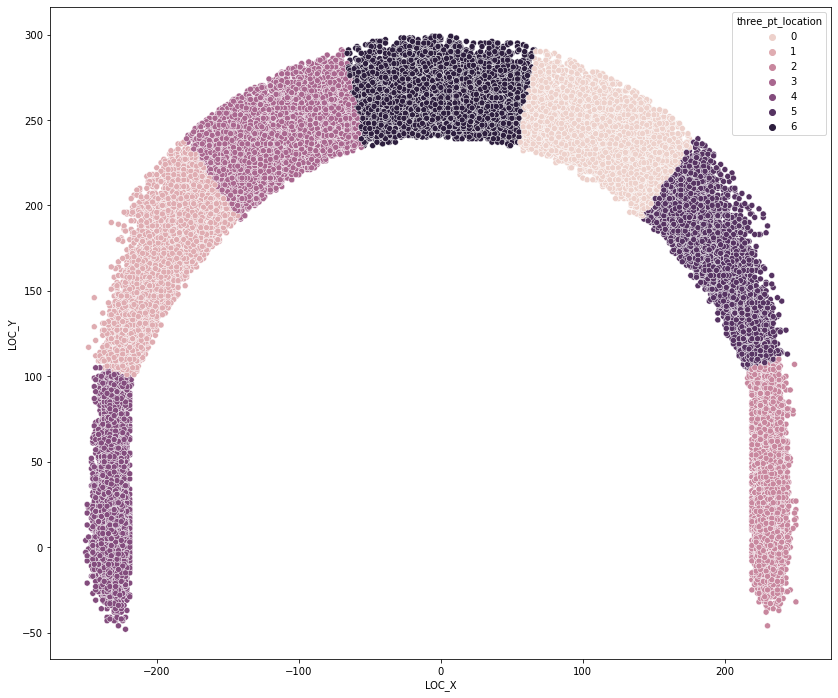

In [15]:
#plotting these 7clusters on the 3pt zone:
plt.figure(figsize = (14,12))
sns.scatterplot(data =df_3pt, x='LOC_X', y = 'LOC_Y', hue = 'three_pt_location')
plt.show()

### We want to have descriptive names of each of these cluster zones. 
We are giving each of these clusters names by map their locations:

In [16]:
# creating a new column with the location names:
df_3pt['location'] = df_3pt['three_pt_location'].map({0: 'R Above Break', 1: 'L Above Break',2:'L Below Break/Corner',3:'R Center',4:'R Below Break/Corner',5:'Center',6:'L Center'})

In [17]:
#creating a variable to use for applying clusters to 3pt only shots
#note: 2pt shots will be NaN
location_column = df_3pt[['three_pt_location']]

In [18]:
#merging the applying the clusters:
df_shots = df_shots.merge(location_column, how = 'left', left_index = True, right_index = True)

In [19]:
df_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,three_pt_location
0,Shot Chart Detail,22100014,42,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,8,14,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,64,1,1,20211021,ATL,DAL,2.0
1,Shot Chart Detail,22100014,47,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,7,47,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,91,232,1,1,20211021,ATL,DAL,0.0
2,Shot Chart Detail,22100014,305,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,2,1,44,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,6,79,1,0,20211021,ATL,DAL,NaN
3,Shot Chart Detail,22100014,362,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,9,40,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,69,1,1,20211021,ATL,DAL,2.0
4,Shot Chart Detail,22100014,433,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,4,24,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,134,210,1,0,20211021,ATL,DAL,0.0


## Let's see if this works!
Creating a Test case using the Spurs and Keldon Johnson.

In [20]:
team_id = teams.find_team_by_abbreviation('SAS')['id'] # For SA Spurs

player_id = players.find_players_by_full_name("Keldon Johnson")[0]['id'] # For Keldon Johnson

game_id = '0022100010' # First game of year Spurs vs. Magic - note that game id must be converted to an int in df_shots

### We are using the `win_probability` api endpoint for a base of the analysis dataframe.

In [22]:
# Select for a single game
df_base = winprobabilitypbp.WinProbabilityPBP(game_id).get_data_frames()[0]

#### We started with the win_prob endpoint as this houses play-by-play by second/minutes. 
We need to then have a `absolute_time` in game seconds since the play started.

In [23]:
# Utilize user function to create absolute time (in seconds) column
df_base['abs_time'] = np.where(df_base.PERIOD <5,
                     ((df_base.PERIOD - 1) * 720 + (720 - df_base.SECONDS_REMAINING)),
                     (2880 + (df_base.PERIOD - 5) * 300 + (300 - df_base.SECONDS_REMAINING)))

### Adding on the Rotation Dataframe so we can have each players' minutes of play vs rest times.

In [24]:
df_rotation = gamerotation.GameRotation(game_id).get_data_frames()

'Game Rotation' returns all the minutes (play time in the court) for every player in the game, seperated into Home and Visitor Dataframes.  As such we search through players for the records with our player_id.  Returns a dataframe holding their rotational stats, most importantly in_time and out_time.

In [25]:
#for-loop to cycle through the players (by ID) in the rotation df
#to then grab their times:
for i in range(2):
    for player in df_rotation[i].PERSON_ID:
        if player == player_id:
            df_player_roto = df_rotation[i][df_rotation[i].PERSON_ID == player]

We need to convert the rotational time in 1/10ths of second, into seconds, then isolate those times out.

In [26]:
df_player_roto['abs_in_time'] = df_player_roto.IN_TIME_REAL/10
df_player_roto['abs_out_time'] = df_player_roto.OUT_TIME_REAL/10
df_player_roto_times = df_player_roto[['abs_in_time','abs_out_time']].reset_index(drop = 'True')

Using a zip function, we are putting together the in and out times together.

In [27]:
zipped = list(zip(df_player_roto_times.abs_in_time, df_player_roto_times.abs_out_time))

In [28]:
#showing what it looks like now:
zipped

[(0.0, 501.0), (856.0, 1322.0), (1440.0, 1817.0), (2271.0, 2586.0)]

#### Let's filter out the times of the game (from the df_base of  win_prob) that align with the player's play time.

In [29]:
# Let me create a holder dataframe as I pull slices off from the base
df_player_game = pd.DataFrame()
for tuplez in zipped:
    df_slice = df_base[(df_base.abs_time >= tuplez[0]) & (df_base.abs_time <= tuplez[1])]
    df_player_game = pd.concat([df_player_game, df_slice])
df_player_game

,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time
0,0022100010,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:43 PM EST),,12:00,1.0,0.0
1,0022100010,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Poeltl vs. Bamba: Tip to Johnson,h,12:00,1.0,0.0
2,0022100010,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN,1.0
3,0022100010,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN,2.0
4,0022100010,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,0022100010,632.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SPURS Rebound,h,4:54,1.0,2586.0
2750,0022100010,633.0,NaN,NaN,109,84,25,4,294.0,1.0,None,Out-of-Bounds,,4:54,0.0,2586.0
2751,0022100010,634.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SUB: Bates-Diop FOR Johnson,h,4:54,1.0,2586.0
2752,0022100010,635.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SUB: Primo FOR White,h,4:54,1.0,2586.0


In [30]:
#testing this out:
df_test = df_player_game.copy()
df_test

,GAME_ID,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD,SECONDS_REMAINING,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time
0,0022100010,2.0,0.58808,0.41192,0,0,0,1,720.0,NaN,None,Start of 1st Period (8:43 PM EST),,12:00,1.0,0.0
1,0022100010,4.0,0.61352,0.38648,0,0,0,1,720.0,1.0,None,Jump Ball Poeltl vs. Bamba: Tip to Johnson,h,12:00,1.0,0.0
2,0022100010,NaN,0.61350,0.38650,0,0,0,1,719.0,1.0,None,None,None,None,NaN,1.0
3,0022100010,NaN,0.61348,0.38652,0,0,0,1,718.0,1.0,None,None,None,None,NaN,2.0
4,0022100010,NaN,0.61346,0.38654,0,0,0,1,717.0,1.0,None,None,None,None,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,0022100010,632.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SPURS Rebound,h,4:54,1.0,2586.0
2750,0022100010,633.0,NaN,NaN,109,84,25,4,294.0,1.0,None,Out-of-Bounds,,4:54,0.0,2586.0
2751,0022100010,634.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SUB: Bates-Diop FOR Johnson,h,4:54,1.0,2586.0
2752,0022100010,635.0,NaN,NaN,109,84,25,4,294.0,1.0,None,SUB: Primo FOR White,h,4:54,1.0,2586.0


In [31]:
df_player_game.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793 entries, 0 to 2753
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GAME_ID            1793 non-null   object 
 1   EVENT_NUM          314 non-null    float64
 2   HOME_PCT           1781 non-null   float64
 3   VISITOR_PCT        1781 non-null   float64
 4   HOME_PTS           1793 non-null   int64  
 5   VISITOR_PTS        1793 non-null   int64  
 6   HOME_SCORE_MARGIN  1793 non-null   int64  
 7   PERIOD             1793 non-null   int64  
 8   SECONDS_REMAINING  1793 non-null   float64
 9   HOME_POSS_IND      1792 non-null   float64
 10  HOME_G             0 non-null      object 
 11  DESCRIPTION        314 non-null    object 
 12  LOCATION           314 non-null    object 
 13  PCTIMESTRING       314 non-null    object 
 14  ISVISIBLE          314 non-null    float64
 15  abs_time           1793 non-null   float64
dtypes: float64(7), int64(4),

In [32]:
#changing GAME_ID to numeric to later add on shot details df:
df_player_game.GAME_ID=pd.to_numeric(df_player_game.GAME_ID)

In [33]:
#checking the dtypes
df_player_game.dtypes

GAME_ID                int64
EVENT_NUM            float64
HOME_PCT             float64
VISITOR_PCT          float64
HOME_PTS               int64
VISITOR_PTS            int64
HOME_SCORE_MARGIN      int64
PERIOD                 int64
SECONDS_REMAINING    float64
HOME_POSS_IND        float64
HOME_G                object
DESCRIPTION           object
LOCATION              object
PCTIMESTRING          object
ISVISIBLE            float64
abs_time             float64
dtype: object

### Creating Shot Details df:

In [34]:
#using abs_time on main df to only include 1-4 periods (no overtime)
#plus the minutes - seconds remaining
df_shots['abs_time'] = np.where(df_shots.PERIOD < 5,
                                (df_shots.PERIOD - 1) * 720 + (720 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)),
                                2880 + ((df_shots.PERIOD - 5) * 300) + (300 - (60 * df_shots.MINUTES_REMAINING) - (df_shots.SECONDS_REMAINING)))

In [35]:
#setting up GAME_ID for this df to be int:
df_game_shots = df_shots[df_shots.GAME_ID == int(game_id)]

In [36]:
#changing the df PLAYER_ID (will change all to lower down below)
df_game_shots = df_game_shots[df_game_shots.PLAYER_ID == player_id]

In [37]:
#resetting the index here:/
df_game_shots.reset_index(drop = True)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,three_pt_location,abs_time
0,Shot Chart Detail,22100010,20,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,10,27,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,16,-134,97,1,1,20211020,SAS,ORL,NaN,93
1,Shot Chart Detail,22100010,70,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,6,52,Made Shot,Reverse Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,-4,1,1,20211020,SAS,ORL,NaN,308
2,Shot Chart Detail,22100010,81,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,5,56,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-20,6,1,0,20211020,SAS,ORL,NaN,364
3,Shot Chart Detail,22100010,212,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,9,11,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-23,7,1,0,20211020,SAS,ORL,NaN,889
4,Shot Chart Detail,22100010,234,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,8,29,Missed Shot,Driving Hook Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,-44,59,1,0,20211020,SAS,ORL,NaN,931
5,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,1067
6,Shot Chart Detail,22100010,267,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,2,1,0,20211020,SAS,ORL,NaN,1067
7,Shot Chart Detail,22100010,330,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,2,48,Made Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,2,65,1,1,20211020,SAS,ORL,NaN,1272
8,Shot Chart Detail,22100010,337,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,2,16,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,15,-157,17,1,1,20211020,SAS,ORL,NaN,1304
9,Shot Chart Detail,22100010,414,1629640,Keldon Johnson,1610612759,San Antonio Spurs,3,9,45,Made Shot,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,23,6,1,1,20211020,SAS,ORL,NaN,1575


In [38]:
#getting the Spurs abbreviations- 
teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation']

'SAS'

In [39]:
#combining home and visitor column with only the Spurs team
df_game_shots['player_h_v'] = np.where(teams.find_teams_by_full_name(df_game_shots.TEAM_NAME.max())[0]['abbreviation'] == df_game_shots.HTM, 'Home', 'Visitor')

### Merging main_df with the Shot details df:

In [40]:
df_almostthere = df_player_game.merge(df_game_shots, how = 'inner', on = 'abs_time')

In [41]:
df_almostthere

,GAME_ID_x,EVENT_NUM,HOME_PCT,VISITOR_PCT,HOME_PTS,VISITOR_PTS,HOME_SCORE_MARGIN,PERIOD_x,SECONDS_REMAINING_x,HOME_POSS_IND,HOME_G,DESCRIPTION,LOCATION,PCTIMESTRING,ISVISIBLE,abs_time,GRID_TYPE,GAME_ID_y,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD_y,MINUTES_REMAINING,SECONDS_REMAINING_y,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,three_pt_location,player_h_v
0,22100010,20.0,0.55487,0.44513,5,7,-2,1,627.0,0.0,None,Johnson 17' Pullup Jump Shot (3 PTS),h,10:27,1.0,93.0,Shot Chart Detail,22100010,20,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,10,27,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,16,-134,97,1,1,20211020,SAS,ORL,NaN,Home
1,22100010,70.0,0.50397,0.49603,13,17,-4,1,412.0,0.0,None,Johnson Reverse Dunk (6 PTS) (White 1 AST),h,6:52,1.0,308.0,Shot Chart Detail,22100010,70,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,6,52,Made Shot,Reverse Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,-4,1,1,20211020,SAS,ORL,NaN,Home
2,22100010,81.0,0.52545,0.47455,13,17,-4,1,356.0,1.0,None,MISS Johnson 2' Driving Layup,h,5:56,1.0,364.0,Shot Chart Detail,22100010,81,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,5,56,Missed Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-20,6,1,0,20211020,SAS,ORL,NaN,Home
3,22100010,212.0,0.67537,0.32463,39,36,3,2,551.0,1.0,None,MISS Johnson 2' Layup#@#Bamba BLOCK (2 BLK),h,9:11,1.0,889.0,Shot Chart Detail,22100010,212,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,9,11,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-23,7,1,0,20211020,SAS,ORL,NaN,Home
4,22100010,234.0,0.67639,0.32361,39,36,3,2,509.0,1.0,None,MISS Johnson 7' Driving Hook Shot,h,8:29,1.0,931.0,Shot Chart Detail,22100010,234,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,8,29,Missed Shot,Driving Hook Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,-44,59,1,0,20211020,SAS,ORL,NaN,Home
5,22100010,267.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,MISS Johnson 1' Layup,h,6:13,1.0,1067.0,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,Home
6,22100010,267.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,MISS Johnson 1' Layup,h,6:13,1.0,1067.0,Shot Chart Detail,22100010,267,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,2,1,0,20211020,SAS,ORL,NaN,Home
7,22100010,268.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,Johnson REBOUND (Off:2 Def:1),h,6:13,1.0,1067.0,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,Home
8,22100010,268.0,0.73307,0.26693,43,38,5,2,373.0,1.0,None,Johnson REBOUND (Off:2 Def:1),h,6:13,1.0,1067.0,Shot Chart Detail,22100010,267,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,2,1,0,20211020,SAS,ORL,NaN,Home
9,22100010,269.0,0.76172,0.23828,45,38,7,2,373.0,0.0,None,Johnson Tip Layup Shot (8 PTS),h,6:13,1.0,1067.0,Shot Chart Detail,22100010,269,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,6,13,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20211020,SAS,ORL,NaN,Home


In [42]:
#adding in the column score_margin that holds the home score margins:
df_almostthere['score_margin'] = np.where(df_almostthere.player_h_v == 'Home', df_almostthere.HOME_SCORE_MARGIN, df_almostthere.HOME_SCORE_MARGIN * -1)

In [43]:
#since we get two columns for every game (Home vs Visitor)
#we want to drop and only hold the Spurs with whichever
#they are (H or V) and only show those win percentages:

if df_almostthere.loc[0,'player_h_v'] == 'Home':
    df_almostthere = df_almostthere.drop(columns = ['VISITOR_PCT'])
    df_almostthere = df_almostthere.rename(columns = {'HOME_PCT':"WIN_PCT"})
else:
    df_almostthere = df_almostthere.drop(columns = ['HOME_PCT'])
    df_almostthere = df_almostthere.rename(columns = {'VISITOR_PCT':"WIN_PCT"})

In [44]:
#creating a column `play_points` that 
df_almostthere['play_points'] = np.where(df_almostthere.SHOT_TYPE == '2PT Field Goal',
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 2,0),
                                    np.where(df_almostthere.SHOT_MADE_FLAG == 1, 3,0))

In [45]:
df_almostthere['points'] = df_almostthere['play_points'].cumsum()

In [46]:
df_almostthere['shots_taken'] = df_almostthere['SHOT_ATTEMPTED_FLAG'].cumsum()
df_almostthere['shots_hit'] = df_almostthere['SHOT_MADE_FLAG'].cumsum()
df_almostthere['game_pct'] = round(df_almostthere['shots_hit']/df_almostthere['shots_taken'],2)

In [47]:
df_almostthere.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GAME_ID_x            17 non-null     int64  
 1   EVENT_NUM            17 non-null     float64
 2   WIN_PCT              17 non-null     float64
 3   HOME_PTS             17 non-null     int64  
 4   VISITOR_PTS          17 non-null     int64  
 5   HOME_SCORE_MARGIN    17 non-null     int64  
 6   PERIOD_x             17 non-null     int64  
 7   SECONDS_REMAINING_x  17 non-null     float64
 8   HOME_POSS_IND        17 non-null     float64
 9   HOME_G               0 non-null      object 
 10  DESCRIPTION          17 non-null     object 
 11  LOCATION             17 non-null     object 
 12  PCTIMESTRING         17 non-null     object 
 13  ISVISIBLE            17 non-null     float64
 14  abs_time             17 non-null     float64
 15  GRID_TYPE            17 non-null     objec

In [48]:
columns_to_drop = [
    'GAME_ID_x',
    'EVENT_NUM',
    'HOME_PTS',
    'VISITOR_PTS',
    'HOME_SCORE_MARGIN',
    'PERIOD_x',
    'SECONDS_REMAINING_x',
    'HOME_POSS_IND',
    'HOME_G',
    'LOCATION',
    'PCTIMESTRING',
    'ISVISIBLE',
    'GRID_TYPE',
    'GAME_EVENT_ID',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING_y',
    'SHOT_ZONE_BASIC',
    'SHOT_ZONE_AREA',
    'SHOT_ZONE_RANGE',
    'LOC_X',
    'LOC_Y',
    'SHOT_ATTEMPTED_FLAG',
    'SHOT_MADE_FLAG',
    'GAME_DATE',
    'HTM',
    'VTM']

In [49]:
df_almostthere = df_almostthere.drop(columns = columns_to_drop)

In [50]:
df_almostthere

,WIN_PCT,DESCRIPTION,abs_time,GAME_ID_y,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD_y,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_DISTANCE,three_pt_location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
0,0.55487,Johnson 17' Pullup Jump Shot (3 PTS),93.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Made Shot,Pullup Jump shot,2PT Field Goal,16,NaN,Home,-2,2,2,1,1,1.00
1,0.50397,Johnson Reverse Dunk (6 PTS) (White 1 AST),308.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Made Shot,Reverse Dunk Shot,2PT Field Goal,0,NaN,Home,-4,2,4,2,2,1.00
2,0.52545,MISS Johnson 2' Driving Layup,364.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Missed Shot,Driving Layup Shot,2PT Field Goal,2,NaN,Home,-4,0,4,3,2,0.67
3,0.67537,MISS Johnson 2' Layup#@#Bamba BLOCK (2 BLK),889.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed Shot,Layup Shot,2PT Field Goal,2,NaN,Home,3,0,4,4,2,0.50
4,0.67639,MISS Johnson 7' Driving Hook Shot,931.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed Shot,Driving Hook Shot,2PT Field Goal,7,NaN,Home,3,0,4,5,2,0.40
5,0.73307,MISS Johnson 1' Layup,1067.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Made Shot,Tip Layup Shot,2PT Field Goal,0,NaN,Home,5,2,6,6,3,0.50
6,0.73307,MISS Johnson 1' Layup,1067.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed Shot,Layup Shot,2PT Field Goal,0,NaN,Home,5,0,6,7,3,0.43
7,0.73307,Johnson REBOUND (Off:2 Def:1),1067.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Made Shot,Tip Layup Shot,2PT Field Goal,0,NaN,Home,5,2,8,8,4,0.50
8,0.73307,Johnson REBOUND (Off:2 Def:1),1067.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed Shot,Layup Shot,2PT Field Goal,0,NaN,Home,5,0,8,9,4,0.44
9,0.76172,Johnson Tip Layup Shot (8 PTS),1067.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Made Shot,Tip Layup Shot,2PT Field Goal,0,NaN,Home,7,2,10,10,5,0.50


In [61]:
columns_to_rename = {'WIN_PCT':'win_probability',
                     'DESCRIPTION':'play_description',
                     'GAME_ID_y':'game_id',
                     'PLAYER_ID':'player_id',
                     'PLAYER_NAME':'player',
                     'TEAM_ID':'team_id',
                     'TEAM_NAME':'team',
                     'PERIOD_y':'period',
                     'EVENT_TYPE': 'shot_result',
                     'ACTION_TYPE':'shot_type',
                     'SHOT_TYPE':'2pt_or_3pt',
                     'SHOT_DISTANCE':'distance'}

In [62]:
df_almostthere = df_almostthere.rename(columns = columns_to_rename)

In [63]:
#df_game_player_target = df_almostthere[df_almostthere['2pt_or_3pt'] == '3PT Field Goal']

In [65]:
df_almostthere.head()

,win_probability,play_description,abs_time,game_id,player_id,player,team_id,team,period,shot_result,shot_type,2pt_or_3pt,distance,three_pt_location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
0,0.55487,Johnson 17' Pullup Jump Shot (3 PTS),93.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Made Shot,Pullup Jump shot,2PT Field Goal,16,NaN,Home,-2,2,2,1,1,1.00
1,0.50397,Johnson Reverse Dunk (6 PTS) (White 1 AST),308.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Made Shot,Reverse Dunk Shot,2PT Field Goal,0,NaN,Home,-4,2,4,2,2,1.00
2,0.52545,MISS Johnson 2' Driving Layup,364.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Missed Shot,Driving Layup Shot,2PT Field Goal,2,NaN,Home,-4,0,4,3,2,0.67
3,0.67537,MISS Johnson 2' Layup#@#Bamba BLOCK (2 BLK),889.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed Shot,Layup Shot,2PT Field Goal,2,NaN,Home,3,0,4,4,2,0.50
4,0.67639,MISS Johnson 7' Driving Hook Shot,931.0,22100010,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed Shot,Driving Hook Shot,2PT Field Goal,7,NaN,Home,3,0,4,5,2,0.40


### Add on's for clean up:

In [66]:
#let's reset the index to game_id:
#first, setting index:
df_almostthere.set_index('game_id', inplace=True)

In [67]:
#replacing shot_result string to only say 'missed' and 'made'
df_almostthere.shot_result = df_almostthere.shot_result.replace({'Missed Shot':'Missed', 'Made Shot':'Made'})

In [69]:
df_almostthere.head()

,win_probability,play_description,abs_time,player_id,player,team_id,team,period,shot_result,shot_type,2pt_or_3pt,distance,three_pt_location,player_h_v,score_margin,play_points,points,shots_taken,shots_hit,game_pct
game_id,,,,,,,,,,,,,,,,,,,,
22100010,0.55487,Johnson 17' Pullup Jump Shot (3 PTS),93.0,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Made,Pullup Jump shot,2PT Field Goal,16,NaN,Home,-2,2,2,1,1,1.00
22100010,0.50397,Johnson Reverse Dunk (6 PTS) (White 1 AST),308.0,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Made,Reverse Dunk Shot,2PT Field Goal,0,NaN,Home,-4,2,4,2,2,1.00
22100010,0.52545,MISS Johnson 2' Driving Layup,364.0,1629640,Keldon Johnson,1610612759,San Antonio Spurs,1,Missed,Driving Layup Shot,2PT Field Goal,2,NaN,Home,-4,0,4,3,2,0.67
22100010,0.67537,MISS Johnson 2' Layup#@#Bamba BLOCK (2 BLK),889.0,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed,Layup Shot,2PT Field Goal,2,NaN,Home,3,0,4,4,2,0.50
22100010,0.67639,MISS Johnson 7' Driving Hook Shot,931.0,1629640,Keldon Johnson,1610612759,San Antonio Spurs,2,Missed,Driving Hook Shot,2PT Field Goal,7,NaN,Home,3,0,4,5,2,0.40


________________________________________________

In [87]:
#plotting data for shots in game:
shotsGame = df_almostthere[['abs_time','play_points','points','shots_taken','shots_hit','three_pt_location','2pt_or_3pt']].drop_duplicates()

In [96]:
#just looking at what it holds:
shotsGame.head()

,abs_time,play_points,points,shots_taken,shots_hit,three_pt_location,2pt_or_3pt
game_id,,,,,,,
22100010,93.0,2,2,1,1,NaN,2PT Field Goal
22100010,308.0,2,4,2,2,NaN,2PT Field Goal
22100010,364.0,0,4,3,2,NaN,2PT Field Goal
22100010,889.0,0,4,4,2,NaN,2PT Field Goal
22100010,931.0,0,4,5,2,NaN,2PT Field Goal


#### Looking at where Keldon is taking the most 3pt shots this game:

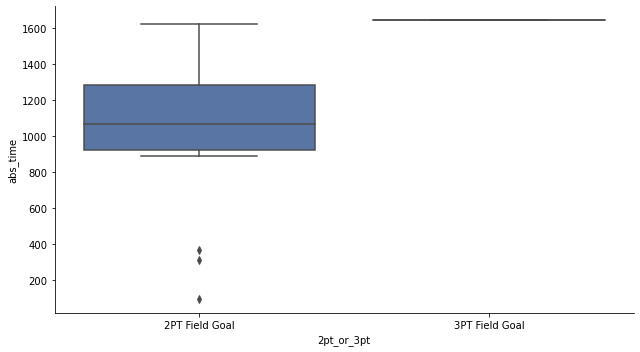

In [95]:
sns.catplot(data=shotsGame, kind='box', x='2pt_or_3pt', y='abs_time', aspect=1.8, palette ='deep')

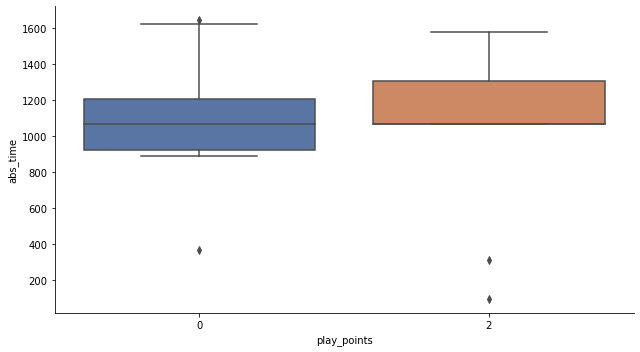

In [98]:
sns.catplot(data=shotsGame, kind='box', x='play_points', y='abs_time', aspect=1.8, palette ='deep')

__________________________